<a href="https://colab.research.google.com/github/andrewjohnlowe/CoreML/blob/main/CoreML_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Core ML Clustering

Loading the dataset as described in the homework task description:

In [ ]:
! pip install bds_courseware
from bds_courseware import read_drive_dataset
from bds_courseware import print_dataset_description, print_module_datasets
from bds_courseware import HOMEWORK_DATASETS
print("Dataset names: ", HOMEWORK_DATASETS.keys())
name = "quake"
df = read_drive_dataset(*HOMEWORK_DATASETS[name])
print(df.head(2))
print(df.shape)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Dataset names:  dict_keys(['suicide_rates', 'car_perfs', 'brain', 'bank', 'air_quality', 'hypothyroid', 'movies', 'bike_sharing_day', 'bike_sharing_hour', 'quake'])
   Focal depth  Latitude  Longitude  Richter
0           33    -52.26      28.30      6.7
1           36     45.53     150.93      5.8
(2178, 4)


## Exploratory data analysis

Let's see if there are any specific characteristics of features which may change the result of the analysis:

In [ ]:
df.describe()

Focal depth     Latitude    Longitude      Richter
count  2178.000000  2178.000000  2178.000000  2178.000000
mean     74.359963     7.961997    54.914835     5.977181
std     116.467797    30.545583   118.875581     0.189426
min       0.000000   -66.490000  -179.960000     5.800000
25%      21.000000   -12.432500   -67.782500     5.800000
50%      39.000000     0.210000   122.100000     5.900000
75%      68.000000    36.480000   146.860000     6.100000
max     656.000000    78.150000   180.000000     6.900000

Pandas profiling is a good tool to get a quick bird's eye view of the data:

In [ ]:
! yes | pip uninstall pandas-profiling
! pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

Found existing installation: pandas-profiling 3.2.0
Uninstalling pandas-profiling-3.2.0:
  Would remove:
    /usr/local/bin/pandas_profiling
    /usr/local/lib/python3.7/dist-packages/pandas_profiling-3.2.0.dist-info/*
    /usr/local/lib/python3.7/dist-packages/pandas_profiling/*
Proceed (y/n)?   Successfully uninstalled pandas-profiling-3.2.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached https://github.com/pandas-profiling/pandas-profiling/archive/master.zip (21.8 MB)
  Created wheel for pandas-profiling: filename=pandas_profiling-3.2.0-py2.py3-none-any.whl size=262599 sha256=ce10a56725e0d6008027706e0da184243d0785f9137011578c01d1f118533ad8
  Stored in directory: /tmp/pip-ephem-wheel-cache-19qu95d7/wheels/cc/d5/09/083fb07c9363a2f45854b0e3a7de7d7c560f07da74b9e9769d
Successfully built pandas-profiling


In [ ]:
from pandas_profiling import ProfileReport

# Generate a profile report for the data:
profile = ProfileReport(
    df, 
    title = "Earthquake data", 
    html = {"style": {"full_width": True}}
    )
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

The feature *Focal depth* has 145 (6.7%) zeros. The focal depth is the depth from the Earth's surface to the region where an earthquake's energy originates (the hypocenter or focus). The foci of most earthquakes are concentrated in the crust and upper mantle up to a depth of 700 km. I'm not a geologist and know very little about earthquakes, so I don't know if zero is a reasonable value for the focal depth of an earthquake. 

The data contains geographical data on the location, depth and size of earthquakes. The obvious thing to do with this data is to plot it on a map. So let's do that (this took a bit of experimentation to get right):

In [ ]:
! pip install geopandas
! pip install contextily
! pip install pyyaml==5.4.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
import contextily as cx
import warnings
warnings.simplefilter(action = 'ignore', category = Warning)

countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.crs.to_string() # I need this string later

'EPSG:4326'

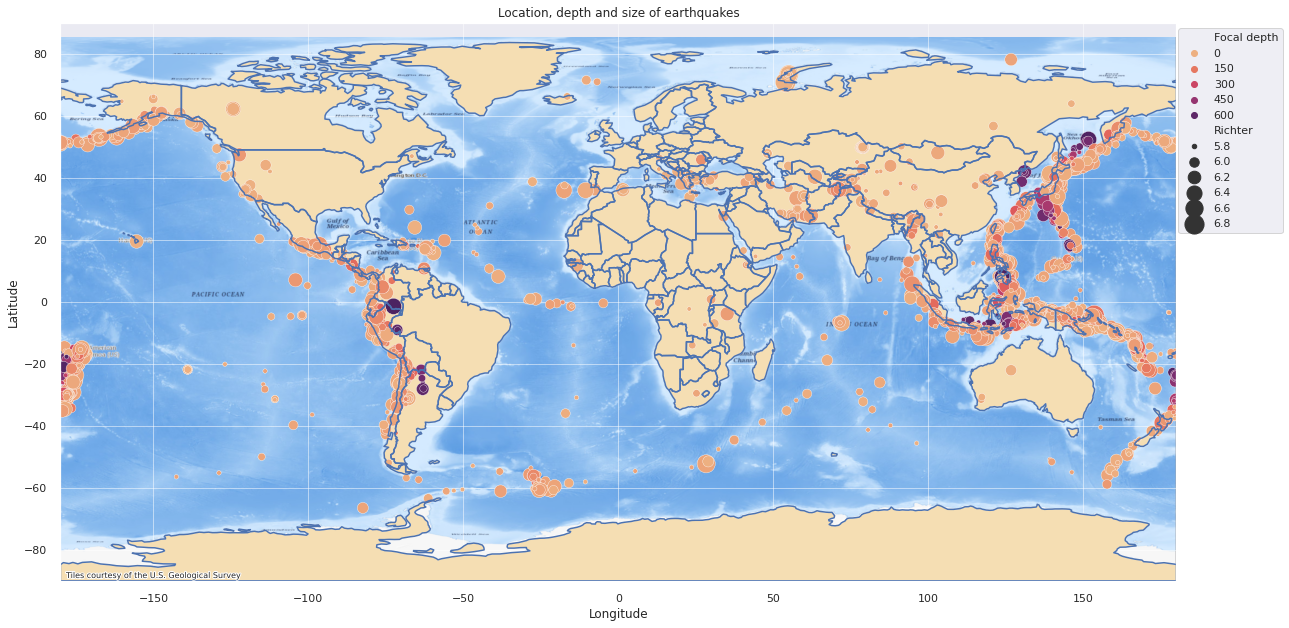

In [ ]:
fig, ax = plt.subplots(figsize = (20,15))
countries.plot(color = "wheat", ax = ax)
countries.boundary.plot(ax = ax)

# Add data:
sns.scatterplot(data = df, x = 'Longitude', y = 'Latitude', size = 'Richter', hue = df['Focal depth'], sizes = (20, 400), alpha = 1, palette = "flare")

# Add grid:
ax.grid(b = True, alpha = 0.5)
ax.set_xlim(-180, 180)
ax.set_ylim(-90, 90)

# This next line often crashes on the first try. I don't know why. Just run this cell again if this happens.
cx.add_basemap(ax, crs = 'EPSG:4326', source = cx.providers.USGS.USTopo)

sns.move_legend(
    ax, "upper right",
    bbox_to_anchor = (1.1, 1),
    frameon = True,
)

plt.title("Location, depth and size of earthquakes")
plt.show()

The regions with frequent high-magnitude earthquakes correspond to Earth's major subduction zones — areas where tectonic plates are colliding. This can be seen in the following map showing the distribution of subduction zones on the Earth:

![Distribution of subduction zones on the Earth (Encyclopædia Britannica).](https://cdn.britannica.com/65/105565-050-D594D7F0/plates-jigsaw-puzzle-crust-Earth-types-motion.jpg)


We might ask the following question: given the information provide by this map, can we estimate how many subduction zones are there? It's difficult to say. There seems to be some major activity where the Pacific plate meets the Eurasian and India-Australia plate. But is that one zone, two zones, or maybe three? How many major subduction zones are there? Maybe three? Four? Five? More? We have the benefit of being able to see the data projected in two dimensions, and yet it's not entirely clear how many earthquake clusters we expect to find in the data. Surely it's a number greater than one. I'd take a guess at more than two, but less than half a dozen.

## Feature engineering

One obvious feature of the data is that the points are not distributed on a Euclidean plane, but on a sphere. So, for example, if we assume the Earth is flat, and there is a cluster at the antimeridian, it will be bisected and k-means will find two clusters. We need to map the data points to a sphere and then run k-means. Note that latitude is measured from the equator in this map projection, but spherical polar coordinates measure $\theta$ from the positive $z$-axis, so we need to account for that. And also convert everything from degrees into radians. I Googled for the radius of the Earth to calculate $r$ for each point, but it's not strictly necessary for clustering the data — I could have assumed a focal depth of zero for every point, and the results would likely be identical, because the variation in $r$ is tiny compared to the variation in the latitude and longitude of the data points.

Here's a diagram I stole from Wikipedia which shows the relationship between spherical polar coordinates and cartesian coordinates. I'll project the data into 3D cartesian space:

![Spherical polar coordinates](https://upload.wikimedia.org/wikipedia/commons/thumb/4/4f/3D_Spherical.svg/480px-3D_Spherical.svg.png)

In [ ]:
R_Earth = 6378.14 #km
df['theta'] = np.radians(90-df['Latitude'])
df['phi'] = np.radians(df['Longitude'])
df['x'] = (R_Earth-df['Focal depth'])*np.sin(df['theta'])*np.cos(df['phi'])
df['y'] = (R_Earth-df['Focal depth'])*np.sin(df['theta'])*np.sin(df['phi'])
df['z'] = (R_Earth-df['Focal depth'])*np.cos(df['theta'])

> *The coordinate mapping was probably the hardest part of this homework. Honestly, a hint or clue would have been helpful. Is this homework supposed to be testing my ability to apply the knowledge and expertise that I acquired in this unit, or my domain knowledge that allowed me to infer that I needed to do a coordinate transformation? Not telling students that they need to transform the data this way is unfair on students who are not as mathematically adept!* 

It would be nice to see the data plotted in 3D, so let's do that:

In [ ]:
! pip install plotly==5.9.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import plotly.express as px
fig = px.scatter_3d(df, x = 'x', y = 'y', z = 'z', 
                    opacity = 0.5,
                    color = 'Focal depth', 
                    hover_data=["Latitude", "Longitude"])
fig.update_traces(marker_size = 1) # Make the fine structure in the data more visible by reducing the marker size
fig.show()

The plot can be rotated to see how the earthquake zones criss-cross the globe.

## Build K-Means with 15 clusters

This is easy.

In [ ]:
from sklearn.cluster import KMeans

Kmean = KMeans(n_clusters = 15, init = 'k-means++', n_init = 10, max_iter = 100, random_state = 42)
Kmean.fit_predict(df[["x", "y", "z"]])

array([ 5,  4,  4, ..., 14,  4, 14], dtype=int32)

## Determine optimal number of clusters for K-Means

We can use the elbow method or a silhouette plot. First, an elbow plot; this shows the *inertia* plotted for various values of $k$, where the inertia is defined as

$$
\sum_{i=0}^{n}(x_i - \mu_k)^2
$$

where $i$ indexes the sample data points and $\mu_k$ are the cluster centroids.

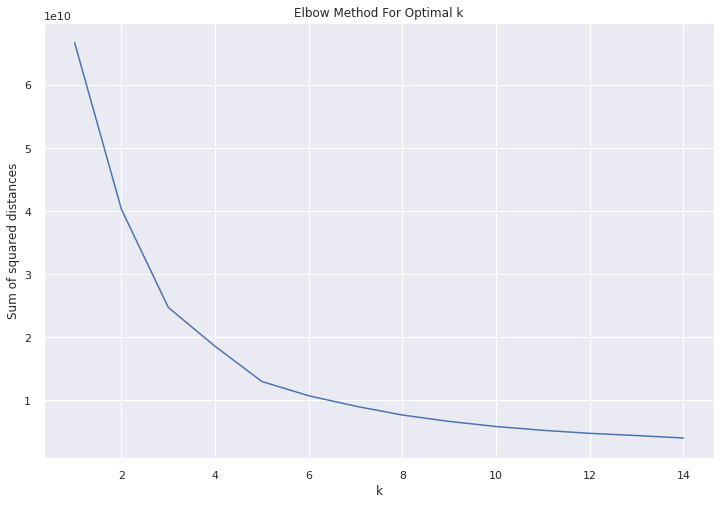

In [ ]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=100, random_state=42)
    km = km.fit(df[["x", "y", "z"]])
    Sum_of_squared_distances.append(km.inertia_)

plt.rcParams["figure.figsize"] = (12,8)
plt.plot(K, Sum_of_squared_distances)
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

Where do we think the elbow is? Do *you* see an elbow? Maybe five clusters seems reasonable. Let's try a silhouette plot next; I'll use YellowBrick to do this, rather than re-inventing the wheel and writing a ton of code needlessly:

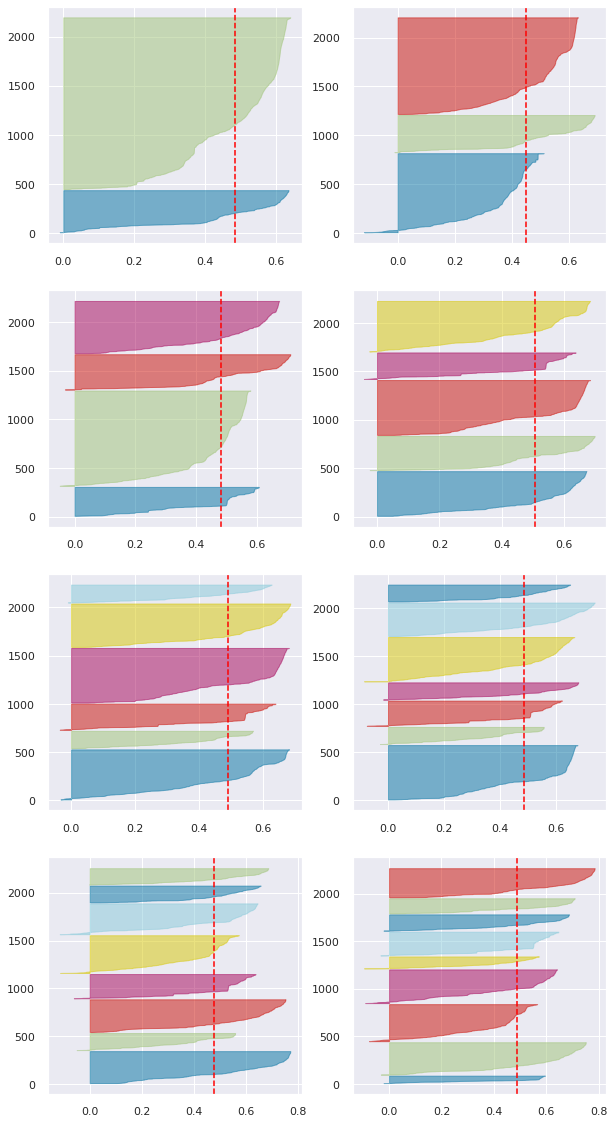

In [ ]:
from yellowbrick.cluster import SilhouetteVisualizer

X = df[["x", "y", "z"]]

fig, ax = plt.subplots(4, 2, figsize=(10,20))
for i in range(2, 10):
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X)

I have to say that this looks rather inconclusive. Also:

> *The theory notes provide a [link](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py) to the sklearn documentation for silhouette analysis, but the documentation doesn't clearly explain how to interpret these plots! I'm still very fuzzy about this.*

It seems that maybe five clusters is a good number, as for the other silhouette plots the silhouettes are of significant unequal thickness and have more variation in their silhouette coefficients.

## Create visualization for the obtained clusters

I've plotted an elbow plot and silhouette plots. What more is required here?

## Try other clustering algorithms; tune their hyperparameters to achieve better results

> *Define "better" — there's no ground truth! I don't see how I can improve on the clustering without mapping the predicted label assignments to the data points shown on the maps, and I'm only able to do that because I can easily visualise the data in 2D, so what do I do if I can't?*

I'll do a brute-force search through a subset of the parameter space for each algorithm to find the values that yield five clusters — I chose this number because I assume I need to compare the results I'll get with the version of K-Means with the optimal value of $k$ found earlier. I don't know if that the intention of the exercise. I'll compare K-Means against DBSCAN, agglomerative (hierarchical) clustering, and OPTICS  the latter chosen because I was very disatisfied with the results I plotted at the end of this notebook. Be prepared to scroll a lot!

In [ ]:
from sklearn.cluster import DBSCAN

for i in np.logspace(0, 4, num = 5):
  for j in np.linspace(5, 50, num = 10):
    db = DBSCAN(eps=i, min_samples=j)
    # print("eps: " + str(i) + " min_samples: " + str(j) + " unique cluster labels found: " + str(np.unique(db.fit_predict(X))))
    print("eps: " + str(i) + " min_samples: " + str(j) + " unique cluster labels found: \n" + str(pd.DataFrame(db.fit_predict(X)).value_counts().sort_index()))

eps: 1.0 min_samples: 5.0 unique cluster labels found: 
-1    2178
dtype: int64
eps: 1.0 min_samples: 10.0 unique cluster labels found: 
-1    2178
dtype: int64
eps: 1.0 min_samples: 15.0 unique cluster labels found: 
-1    2178
dtype: int64
eps: 1.0 min_samples: 20.0 unique cluster labels found: 
-1    2178
dtype: int64
eps: 1.0 min_samples: 25.0 unique cluster labels found: 
-1    2178
dtype: int64
eps: 1.0 min_samples: 30.0 unique cluster labels found: 
-1    2178
dtype: int64
eps: 1.0 min_samples: 35.0 unique cluster labels found: 
-1    2178
dtype: int64
eps: 1.0 min_samples: 40.0 unique cluster labels found: 
-1    2178
dtype: int64
eps: 1.0 min_samples: 45.0 unique cluster labels found: 
-1    2178
dtype: int64
eps: 1.0 min_samples: 50.0 unique cluster labels found: 
-1    2178
dtype: int64
eps: 10.0 min_samples: 5.0 unique cluster labels found: 
-1    2087
 0      55
 1       5
 2      18
 3       6
 4       7
dtype: int64
eps: 10.0 min_samples: 10.0 unique cluster labels found

In [ ]:
from sklearn.cluster import AgglomerativeClustering

for i in np.linspace(0, 300000, num = 31):
  hc = AgglomerativeClustering(distance_threshold = i, n_clusters = None)
  hc.fit_predict(X)
  # print("distance_threshold: " + str(i) + " number of clusters found: " + str(hc.n_clusters_))
  print("distance_threshold: " + str(i) + " unique cluster labels found: \n" + str(pd.DataFrame(hc.fit_predict(X)).value_counts().sort_index()))

distance_threshold: 0.0 unique cluster labels found: 
0       1
1       1
2       1
3       1
4       1
       ..
2173    1
2174    1
2175    1
2176    1
2177    1
Length: 2178, dtype: int64
distance_threshold: 10000.0 unique cluster labels found: 
0      40
1     161
2      23
3      20
4      19
5      96
6      15
7      54
8      48
9      56
10    121
11     76
12     41
13    173
14     95
15     32
16     86
17     43
18     26
19     26
20     37
21     12
22     90
23    130
24     73
25     24
26     69
27    162
28    150
29     76
30      7
31     48
32     49
dtype: int64
distance_threshold: 20000.0 unique cluster labels found: 
0      34
1     186
2      44
3      99
4     246
5     106
6     291
7     252
8      20
9      63
10     40
11     92
12    197
13    173
14     95
15     54
16     86
17     48
18     26
19     26
dtype: int64
distance_threshold: 30000.0 unique cluster labels found: 
0     406
1     396
2     115
3     185
4     140
5      66
6     291
7     252

In [ ]:
from sklearn.cluster import OPTICS

for i in np.logspace(0, 10, base = 2, num = 11):
  opt = OPTICS(min_samples=int(i))
  opt.fit_predict(X)
  print("distance_threshold: " + str(i) + " unique cluster labels found: \n" + str(pd.DataFrame(opt.fit_predict(X)).value_counts().sort_index()))

distance_threshold: 1.0 unique cluster labels found: 
0    2178
dtype: int64
distance_threshold: 2.0 unique cluster labels found: 
-1      434
 0        5
 1        4
 2        3
 3        6
       ... 
 608      4
 609      3
 610      3
 611      4
 612      3
Length: 614, dtype: int64
distance_threshold: 4.0 unique cluster labels found: 
-1      803
 0       10
 1       14
 2        4
 3       19
       ... 
 190      8
 191      4
 192      9
 193      8
 194      4
Length: 196, dtype: int64
distance_threshold: 8.0 unique cluster labels found: 
-1     970
 0       8
 1      12
 2      11
 3       9
      ... 
 79      8
 80      8
 81      9
 82      9
 83      8
Length: 85, dtype: int64
distance_threshold: 16.0 unique cluster labels found: 
-1     879
 0      52
 1      42
 2      37
 3      23
 4      34
 5      20
 6      18
 7      39
 8      21
 9      35
 10     21
 11     27
 12     33
 13     23
 14     27
 15     23
 16     27
 17     28
 18     39
 19     52
 20     29
 2

## Use labelled and unlabeled metrics to estimate quality of clusters

I'll use the hyperparameters I just found for each clustering algorithm that yield five clusters; I also compare the BIRCH algorithm against the results from K-Means, but I didn't bother tuning it — I just wanted to try something else because the results with the other algorithms was so disappointing. 

In [ ]:
Kmean = KMeans(n_clusters = 5)
labels_true = Kmean.fit_predict(X)
hc = AgglomerativeClustering(distance_threshold = 80_000, n_clusters = None)
hc_pred = hc.fit_predict(X)
np.unique(hc_pred)

array([0, 1, 2, 3, 4])

In [ ]:
db = DBSCAN(eps = 1000, min_samples = 35)
db_pred = db.fit_predict(X)
np.unique(db_pred)

array([-1,  0,  1,  2,  3,  4])

In [ ]:
opt = OPTICS(min_samples = 80)
opt_pred = opt.fit_predict(X)
np.unique(opt_pred)

array([-1,  0,  1,  2,  3,  4])

In [ ]:
from sklearn.cluster import Birch

brc = Birch(n_clusters=5)
brc_pred = brc.fit_predict(X)

> *The notes provide a [link](https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation) to the documentation on clustering performance evaluation, but there's no heuristic or guidence on which method to use in a particular situation. This is like saying, "You need to build a coffee table. Here's a hammer, a screwdriver, and a teapot." One or more of those tools might be useful — but which? There's no information on how to determine which tool is best.*

Fine, since nobody said what I should use, I'll use a criterion based on information theory to measure performance:

In [ ]:
from sklearn import metrics

metrics.adjusted_mutual_info_score(labels_true, labels_true) # Sanity check!

1.0

In [ ]:
metrics.adjusted_mutual_info_score(hc_pred, labels_true)

0.839959949559922

In [ ]:
metrics.adjusted_mutual_info_score(db_pred, labels_true)

0.4843571806786329

In [ ]:
metrics.adjusted_mutual_info_score(opt_pred, labels_true)

0.40233775565327684

In [ ]:
metrics.adjusted_mutual_info_score(brc_pred, labels_true)

0.839959949559922

If we assume that the cluster assignments from K-Means are ground truth, hierarchical clustering performs "best" — the results are most similar.

## Explain the final choice of best clusterizations

They're all bad. Some are worse than others. None of them seem to produce clusters that correspond neatly to distinct subduction zones that can be seen on the map. I think I, or another human, could do a better job. I'll explain the deficiencies of eath clustering in the following plots:

### K-Means

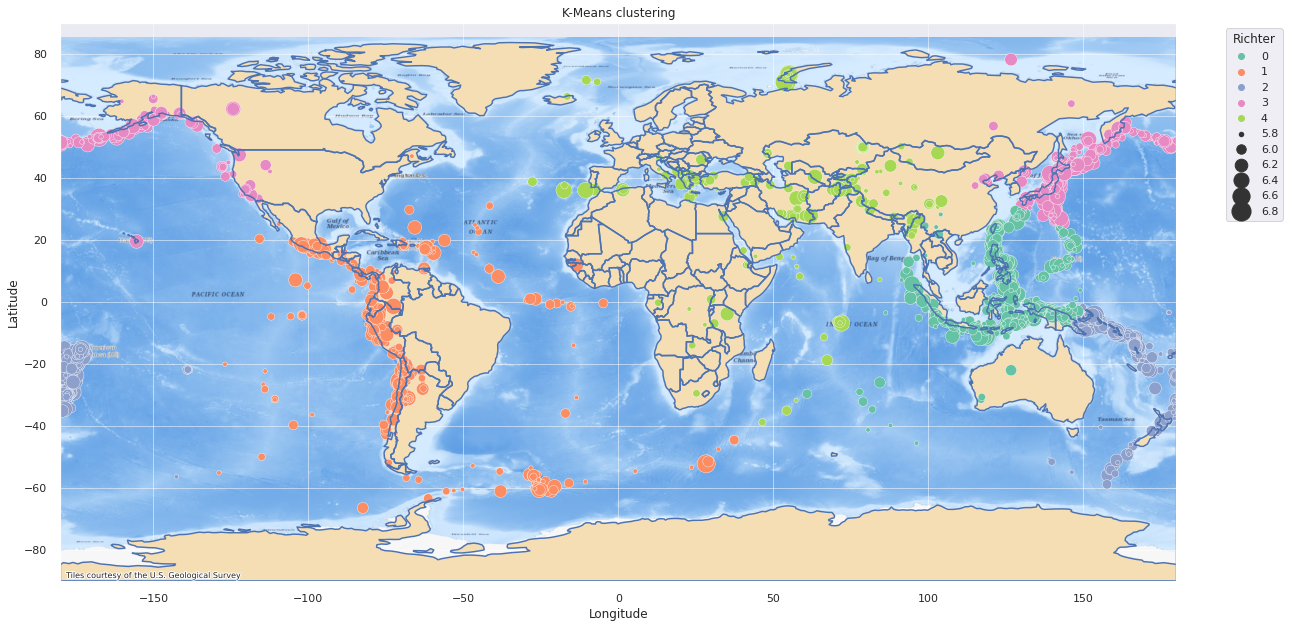

In [ ]:
fig, ax = plt.subplots(figsize = (20,15))
countries.plot(color = "wheat", ax = ax)
countries.boundary.plot(ax = ax)

# Add data:
sns.scatterplot(data = df, x = 'Longitude', y = 'Latitude', size = 'Richter', hue = labels_true, sizes = (20, 400), alpha = 1, palette = "Set2")

# Add grid:
ax.grid(b = True, alpha = 0.5)
ax.set_xlim(-180, 180)
ax.set_ylim(-90, 90)

cx.add_basemap(ax, crs = 'EPSG:4326', source = cx.providers.USGS.USTopo)
sns.move_legend(
    ax, "upper right",
    bbox_to_anchor = (1.1, 1),
    frameon = True,
)

plt.title("K-Means clustering")
plt.show()

K-Means has split the activity in the region where the Pacific plate meets the Eurasian plate into three different clusters, and given what we know about the actual geology of the region, this seems excessive. Moreover, activity on the mid-Atlantic ridge has been lumped togther with activity on the West of the South American plate, and this is clearly not correct. These regions have different physics. This is an unsatisfactory clustering.

### DBSCAN

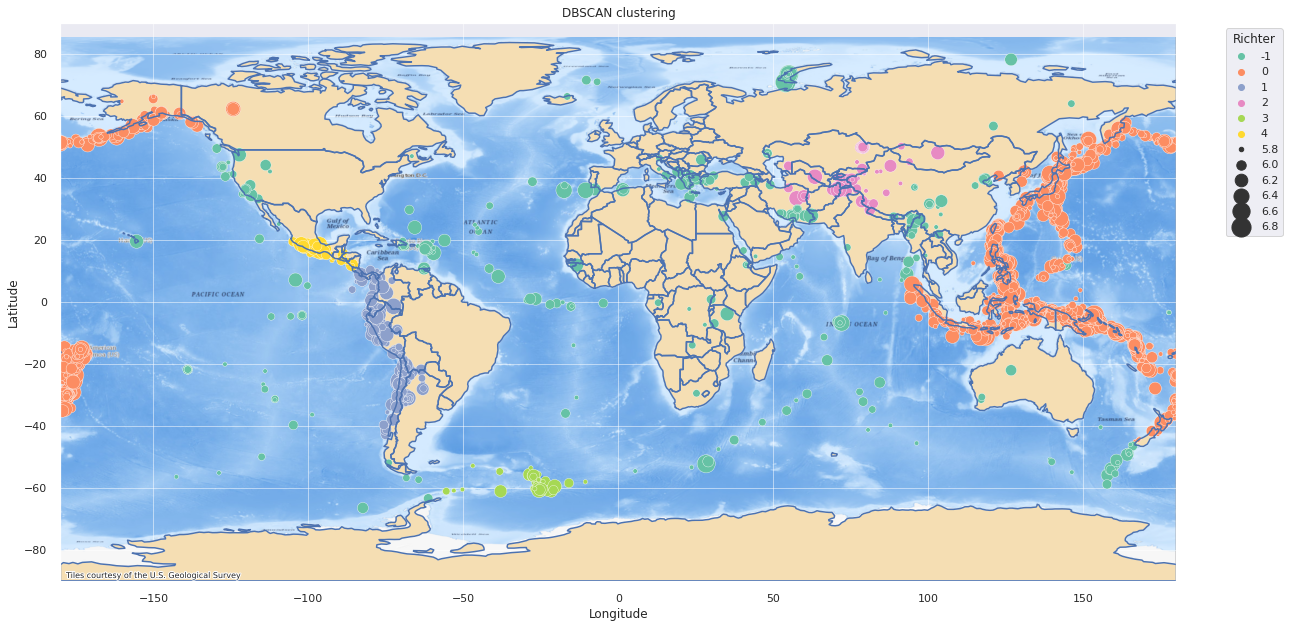

In [ ]:
fig, ax = plt.subplots(figsize = (20,15))
countries.plot(color = "wheat", ax = ax)
countries.boundary.plot(ax = ax)

# Add data:
sns.scatterplot(data = df, x = 'Longitude', y = 'Latitude', size = 'Richter', hue = db_pred, sizes = (20, 400), alpha = 1, palette = "Set2")

# Add grid:
ax.grid(b = True, alpha = 0.5)
ax.set_xlim(-180, 180)
ax.set_ylim(-90, 90)

cx.add_basemap(ax, crs = 'EPSG:4326', source = cx.providers.USGS.USTopo)
sns.move_legend(
    ax, "upper right",
    bbox_to_anchor = (1.1, 1),
    frameon = True,
)

plt.title("DBSCAN clustering")
plt.show()

The clustering obtained from DBSCAN seems to more closely match the underlying physics. We expect that the Pacific plate is responsible for different zones of activity either side of it — it's being compressed as the mid-Atlantic ridge opens. Activity on the Iran and Arabian plate forms a single cluster instead of two, and we'd prefer this not to be the case. The activity in subduction zone where the Antarctic plate meets the South America plate is seen as a distinct cluster — it is nice that DBSCAN has captured this structure in the data. There are a lot of outliers where DBSCAN didn't know what which cluster to assign these points to — ths is good. Machine learning algorithms should sometimes not give an answer when they are unsure!

### Hierarchical clustering

This the clustering result that produced results most like those from K-Means.

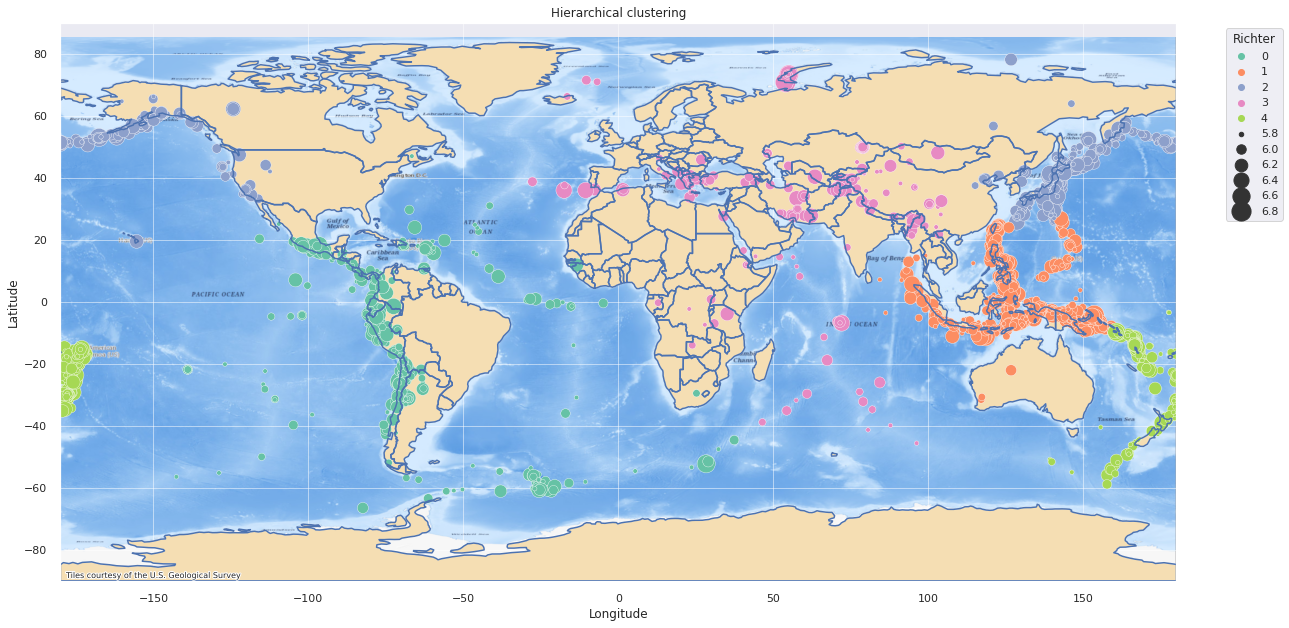

In [ ]:
fig, ax = plt.subplots(figsize = (20,15))
countries.plot(color = "wheat", ax = ax)
countries.boundary.plot(ax = ax)

# Add data:
sns.scatterplot(data = df, x = 'Longitude', y = 'Latitude', size = 'Richter', hue = hc_pred, sizes = (20, 400), alpha = 1, palette = "Set2")

# Add grid:
ax.grid(b = True, alpha = 0.5)
ax.set_xlim(-180, 180)
ax.set_ylim(-90, 90)

cx.add_basemap(ax, crs = 'EPSG:4326', source = cx.providers.USGS.USTopo)
sns.move_legend(
    ax, "upper right",
    bbox_to_anchor = (1.1, 1),
    frameon = True,
)

plt.title("Hierarchical clustering")
plt.show()

As with K-Means, the earthquake activity seems to have been partitioned in a way that doesn't correspond to what we would expect from an understanding of the physics and geology responsible for earthquakes. This isn't a satisfying clustering.

### OPTICS

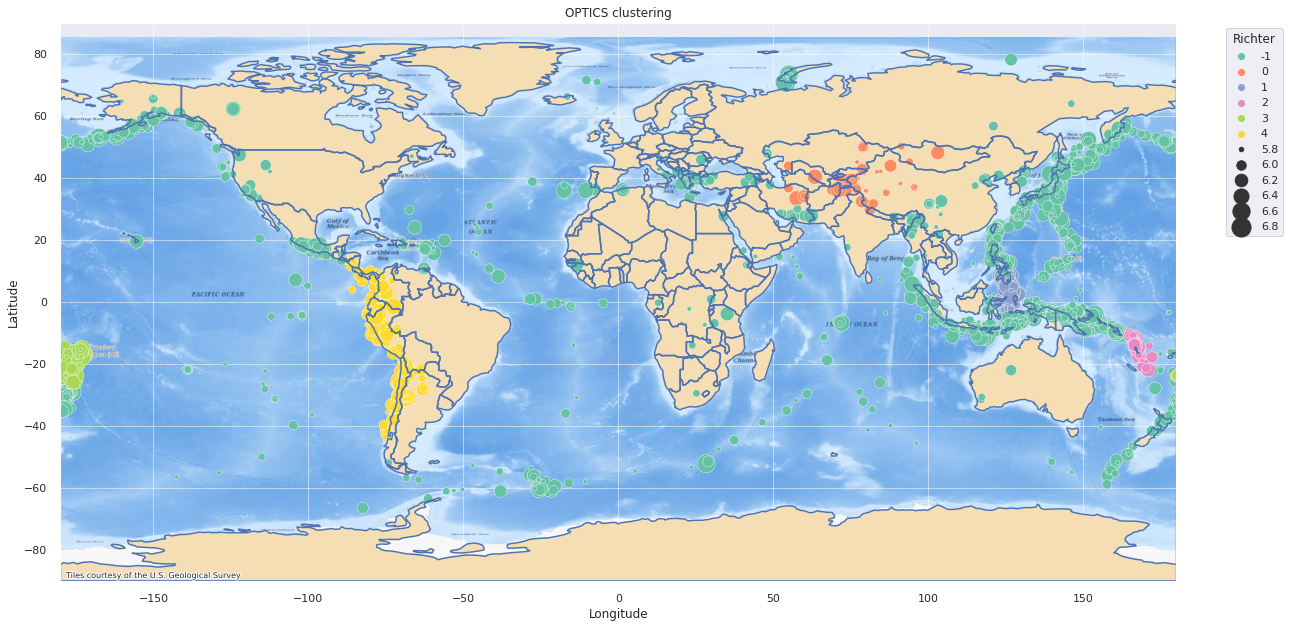

In [ ]:
fig, ax = plt.subplots(figsize = (20,15))
countries.plot(color = "wheat", ax = ax)
countries.boundary.plot(ax = ax)

# Add data:
sns.scatterplot(data = df, x = 'Longitude', y = 'Latitude', size = 'Richter', hue = opt_pred, sizes = (20, 400), alpha = 1, palette = "Set2")

# Add grid:
ax.grid(b = True, alpha = 0.5)
ax.set_xlim(-180, 180)
ax.set_ylim(-90, 90)

cx.add_basemap(ax, crs = 'EPSG:4326', source = cx.providers.USGS.USTopo)
sns.move_legend(
    ax, "upper right",
    bbox_to_anchor = (1.1, 1),
    frameon = True,
)

plt.title("OPTICS clustering")
plt.show()

Nearly every data point is an outlier. OPTICS seems very unsure of how to cluster this data. I did pick parameters to force it to yield five clusters, though. Maybe better clusterings are possible with OPTICS if I don't impose this strict constraint.

### BIRCH

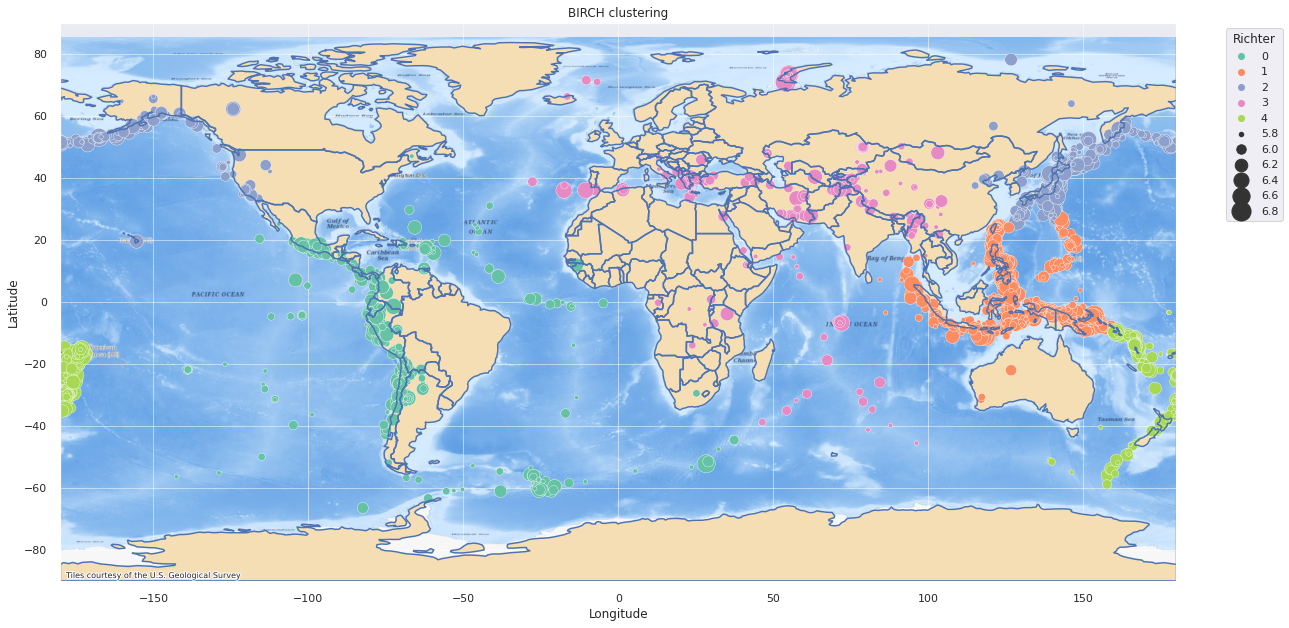

In [ ]:
fig, ax = plt.subplots(figsize = (20,15))
countries.plot(color = "wheat", ax = ax)
countries.boundary.plot(ax = ax)

# Add data:
sns.scatterplot(data = df, x = 'Longitude', y = 'Latitude', size = 'Richter', hue = brc_pred, sizes = (20, 400), alpha = 1, palette = "Set2")

# Add grid:
ax.grid(b = True, alpha = 0.5)
ax.set_xlim(-180, 180)
ax.set_ylim(-90, 90)

cx.add_basemap(ax, crs = 'EPSG:4326', source = cx.providers.USGS.USTopo)
sns.move_legend(
    ax, "upper right",
    bbox_to_anchor = (1.1, 1),
    frameon = True,
)

plt.title("BIRCH clustering")
plt.show()

The results look identical to those I obtained with K-Means. Let's check this:

In [ ]:
metrics.adjusted_mutual_info_score(brc_pred, hc_pred)

1.0

I thought so!

## Summary

DBSCAN, in my opinion, seems to do the best job of capturing the structure in the data. It appears to produce clusters that match expectations based on the physics and geology responsible for the data.